In [1]:
from os.path import join
from matplotlib import pyplot as plt, animation
import numpy as np
import logging
from tqdm import tqdm
import sys
import os

sys.path.append('..')

from autoencoders import default_setting
from autoencoders.default_paths import default_model_dir
from autoencoders.model.conv_ae import ConvAE
from autoencoders.model.combined_ae import CombinedAE
from autoencoders.utils.utils import generate_batches, load_dataset


%matplotlib inline
plt.style.use('dark_background')

# Reduce Tensorflow logs 
# https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR') 


2023-07-18 11:38:11.214634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 11:38:11.854817: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2023-07-18 11:38:13.888692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-18 11:38:13.936245: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


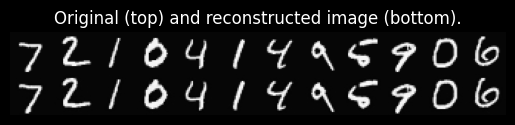

In [2]:
"""
Plot a sample reconstructed images using a convolutional autoencoder (convAE). 

Encoding images using fully convolutional autoencoder allow us to make further 
training and experimentation significantly faster. In particular if we want to train
a large number of models with different latent dimension and hyper-parameters.

This is a popular technique used in recent models such as stable diffusion. 
With sufficient number of latent parameters, we can see that the reconstruction 
is almost perfect. 
"""

# Dataset: mnist or circles
dataset_name = 'mnist'  

model_dir = default_model_dir(dataset_name, 'convAE') 
convAE = ConvAE.load_model(model_dir)

def visualize_cnn_reconstruction():
    nsamples = 12
    
    x_data = load_dataset(dataset_name)['test'][:nsamples]
    x_rec = convAE.reconstruct(x_data)
    
    # convert to a single image
    img = np.concatenate((x_data, x_rec), axis=1)
    img = np.concatenate([x for x in img], axis=1)
    
    plt.title('Original (top) and reconstructed image (bottom).')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

        
visualize_cnn_reconstruction()

In [3]:
"""
Define util functions and load models for stacked autoencoder. 
"""  

# Types of autoencoders to compare: 
#  - VAE = Variational Autoencoder, 
#  - WAE = Wasserstein Autoencoder with MMD loss, 
#  - Vanilla = classical autoencoder without regularized latent space.
model_types = ['VAE', 'WAE', 'Vanilla']

# Latent dimensions to compare
z_dims = [2, 3, 5, 8, 13, 21] 


def load_model(model_type, z_dim):
    """
    Load the two autoencoders (convAE and stackedAE) as a single model.  
    """

    stackedAE_dir = default_model_dir(dataset_name, model_type, suffix=f'zdim{z_dim}')
    combinedAE = CombinedAE.load_model(convAE, stackedAE_dir, model_type)
    return combinedAE


def process_in_chunks(arr, f, tqdm_text=None):
  
    max_chunk_size = 128

    if arr.shape[0] < max_chunk_size:
        return f(arr)

    # split into chunks
    nchunks = np.ceil(arr.shape[0] / max_chunk_size)
    chunks = np.array_split(arr, nchunks)

    processed = [f(chunk) for chunk in tqdm(chunks, tqdm_text)]
    processed = np.concatenate(processed, axis=0)

    return processed


def compute_mse(x, x_rec):
    """
    Compute mean square error. 
    """
    return np.mean((x - x_rec) ** 2) 


# Load all models 
# Note that it would be more eficient to load convolutional autoencoder only once
# model_type -> z_dim -> model
autoencoders = {model_type: {z_dim: load_model(model_type, z_dim) for z_dim in z_dims}
                for model_type in model_types}

    

/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNor

/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/home/marek/Projects/image-autoencoders/venv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNor

Vanilla - zdim 21: 100%|█████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 15.01it/s]


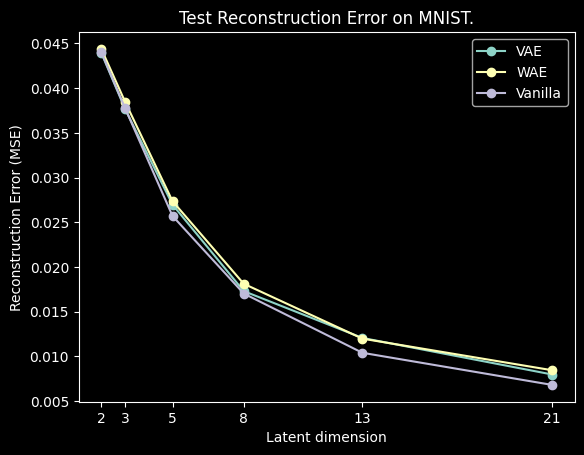

In [4]:
"""
Reconstruction. 

In the following experiments, we compare three different types of latent regularization:
Variational autoencoder (VAE), Wasserstein autoencoder (WAE) and classical 
unregularized vanilla autoencoder. 

First, we compare reconstruction error for all types of models and multiple latent 
dimensions. The reconstruction error is an average test mean squared error. 


We can see that Vanilla autoencoder has the lowest mse. This is expected as it only 
reconstruction error is minimized during the training.

For most latent dimensions, VAE has lower reconstruction eror, which might be caused 
by setting too strong regularization weight for WAE. (A better comparison would be plotting 
multiple WAE models with different regularization strenght.)

Note that: lower reconstruction error does not always lead to a better model 
as models with higher reconstuction error may remove unwanted noise from images. 
"""

sample_size = 1000


def compute_avg_reconstrution_error(x_data, model_type):
    
    for z_dim in z_dims:
        
        # compute reconstruction on the test sample
        autoencoder = autoencoders[model_type][z_dim]
        msg = f'{model_type} - zdim {z_dim}'
        x_rec = process_in_chunks(x_data, autoencoder.reconstruct, msg)
        
        yield compute_mse(x_data, x_rec)
        

def plot_mean_reconstruction_error():
    
    # Get test data sample
    x_data = load_dataset(dataset_name)['test'][:sample_size]    
    
    # Compute the reconstruction error 
    # for each model type and z_dim
    mses = { model_type: list(compute_avg_reconstrution_error(x_data, model_type))
        for model_type in model_types}

    # Plot
    for model_type, mse in mses.items():      
        plt.plot(z_dims, mse, label=model_type, marker = 'o')
    
    plt.title('Test Reconstruction Error on MNIST.')                     
    plt.xlabel('Latent dimension')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.legend(loc='upper right')
    plt.xticks(z_dims)
    plt.show()

plot_mean_reconstruction_error()



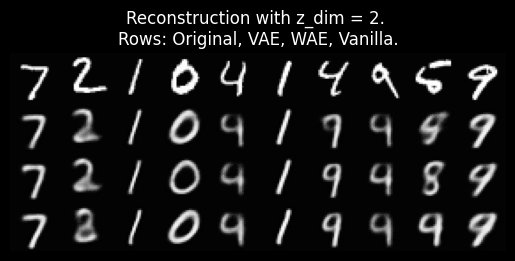

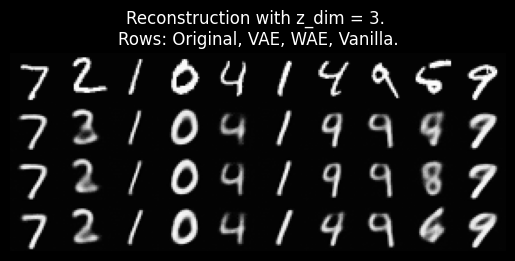

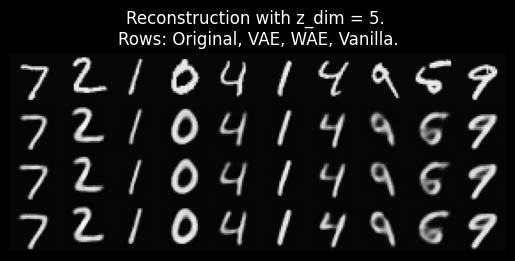

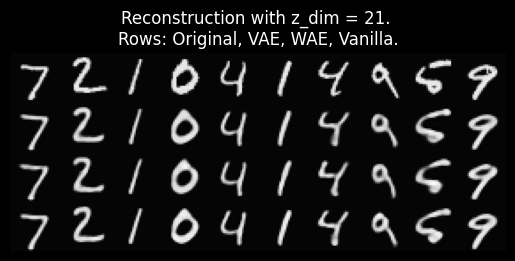

In [5]:
"""
Plot sample reconstructions on test images. 
"""

sample_size = 10

z_dims = [2, 3, 5, 21]

# load data
x_data = load_dataset(dataset_name)['test'][:sample_size]
    

def visualize_reconstuction(x_data, z_dim):
    
    # Compute reconstructions using different models
    x_rec =[autoencoders[model_type][z_dim].reconstruct(x_data)
            for model_type in model_types]

    # Convert into a single image
    img_list = [x_data] + x_rec  # the original + reconstructed
    img = np.concatenate(img_list, axis=1)
    img = np.concatenate(img, axis=1)

    # Plot
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Reconstruction with z_dim = {z_dim}. \nRows: Original, {", ".join(model_types)}.')
    plt.show()

        
for z_dim in z_dims:
    visualize_reconstuction(x_data, z_dim)

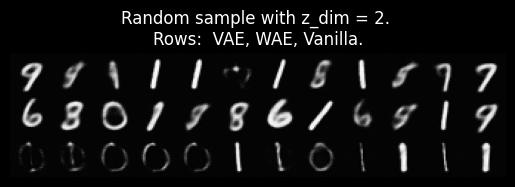

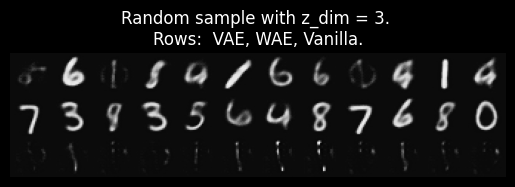

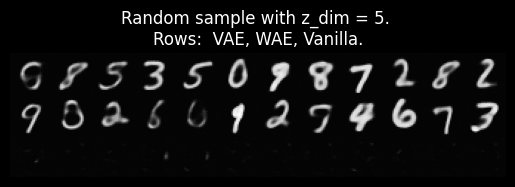

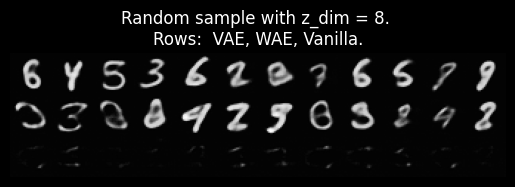

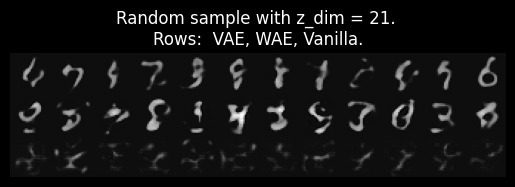

In [6]:
"""
Random samples for latent dimensions 2, 3, 5, 8 and 21.

Both VAE and WAE are trained to have approximately normal distribution N(0, I) 
of the latent space. To sample random images, we sample z from normal 
distribution N(0, I) and apply the model encoder. 

Vanilla autoencoder can be also used to generate random images, but the problem 
is that we don't know the distribution of latent vectors. We can see that the most
of generated images are either noisy or just an empty image. 

When it comes to VAE and WAE, the quality of the generated images seems comparable. 
For latent dimensions 2 and 3, most of generated images seems to be valid digits. 
With increasing dimensionality the sampling becomes harder as most of the latent space 
does not represent anything meaningful 
(see https://en.wikipedia.org/wiki/Curse_of_dimensionality). 

. 
"""

z_dims = [2, 3, 5, 8, 21]
nsamples = 12


def generate_random_images():
    for model_type in model_types:
        # sample z ~ N(0, I)
        z_sample = np.random.randn(nsamples, z_dim)
        images = autoencoders[model_type][z_dim].decode(z_sample)
        yield images


def plot_samples(z_dim):
    
    # Generate random samples using different model types
    images = list(generate_random_images())

    # Convert to a single image
    img = [np.concatenate(img, axis=1) for img in images]
    img = np.concatenate(img, axis=0)
    
    # Plot
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Random sample with z_dim = {z_dim}. \nRows:  {", ".join(model_types)}.')
    plt.show()
    

for z_dim in z_dims:
    plot_samples(z_dim)

Vanilla encode - zdim 2: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.04it/s]


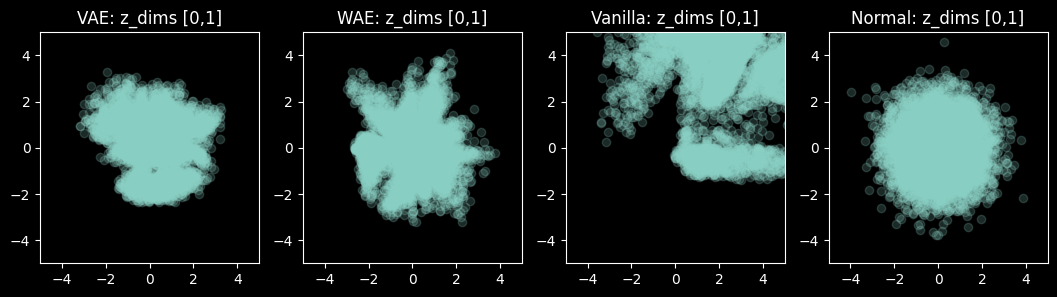

Vanilla encode - zdim 3: 100%|█████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 32.90it/s]


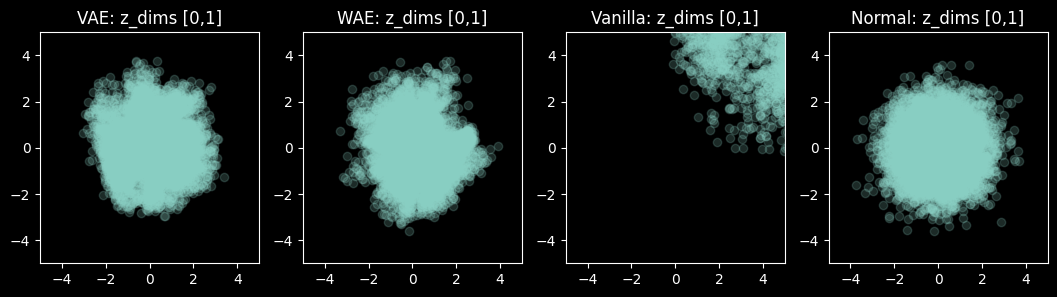

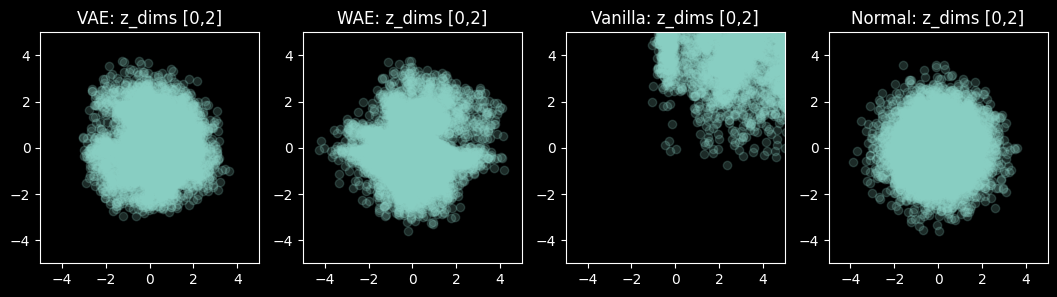

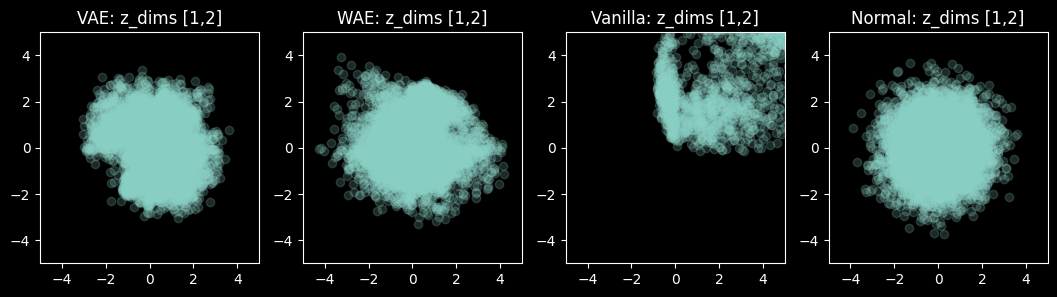

In [7]:
"""
Plot latent distribution. 

-

"""

z_dims = [2, 3]

# get test data
x_data = load_dataset(dataset_name)['test']


def get_test_latents(x_data, z_dim):
    
    # encode the whole test dataset
    for model_type in model_types:
        ae = autoencoders[model_type][z_dim]
        msg = f'{model_type} encode - zdim {z_dim}'
        z_data = process_in_chunks(x_data, ae.deterministic_encode, msg)
        yield z_data

    
def plot_latent_distribution(x_data, z_dim):
    # get latents for all models
    all_z_data = list(get_test_latents(x_data, z_dim))
    
    # add a sample from normal dist for comparison
    all_z_data.append(np.random.randn(*all_z_data[0].shape))
    model_types_ext = model_types + ['Normal']
    
    # iterate over all pairs of latent parameters (z_i, z_j)
    for i in range(z_dim): 
        for j in range(i):
            # plot all model types in parallel
            fig, axs = plt.subplots(1, len(model_types_ext), figsize=(13, 3))

            for ax, model_type, z_data in zip(axs, model_types_ext, all_z_data): 

                ax.set_title(f'{model_type}: z_dims [{j},{i}]')
                ax.scatter(z_data[:, i], z_data[:, j], alpha=0.2)
                ax.set_xlim(-5, 5)
                ax.set_ylim(-5, 5)
            plt.show()


for z_dim in z_dims:    
    plot_latent_distribution(x_data, z_dim)
    

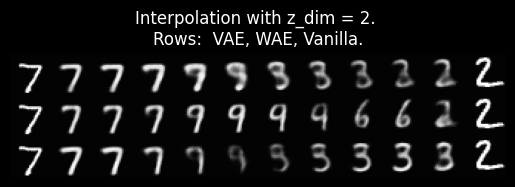

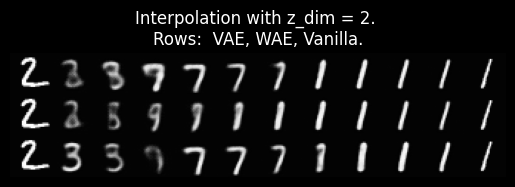

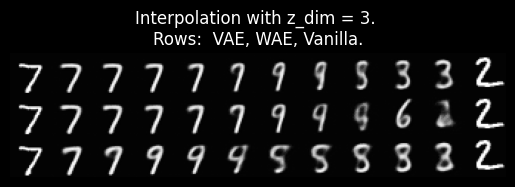

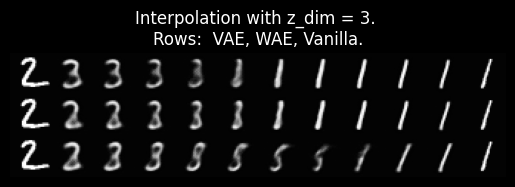

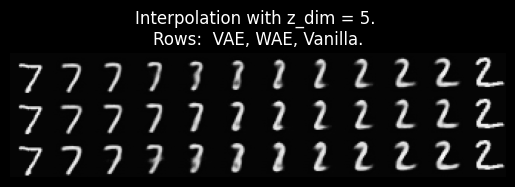

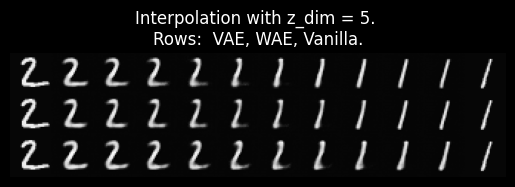

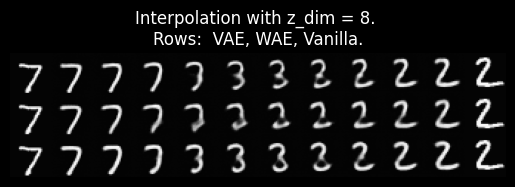

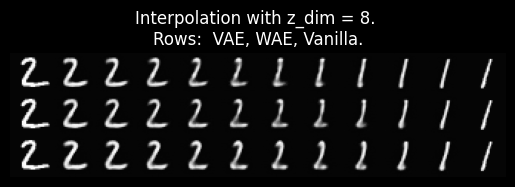

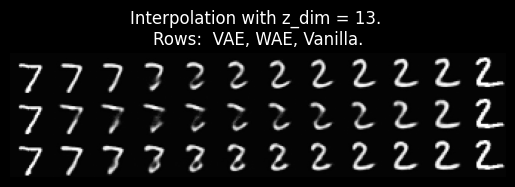

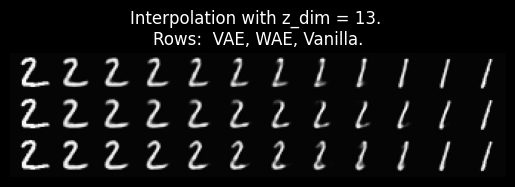

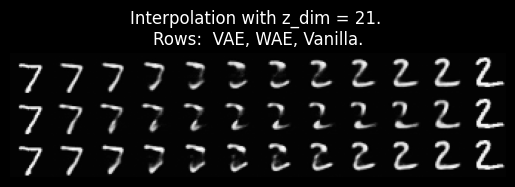

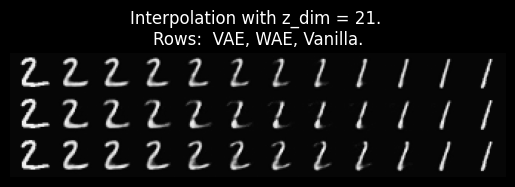

In [13]:
"""
Interpolations between real test images. 


In order to interpolate two images, we encode both of them into latent vectors, 
interpolate latent vectors and for each interpolated latent vectors generate an intermediate image. 

For MNIST digits, it's not obvious what should be wanted behaviour here. 

Do we prefer all interpolated images to look like valid digits?
Or would we prefer having smooth transition between two numbers? 

Example: Say we want to interpolate between "1" and "0". Is it preferable to have 
the interpolated image that's a valid "6" digit or something that's not a valid 
number, but looks more like something between "1" and "0"?

Depending on the application we might have differet preferences. 

This behaviour can be influenced by our choice of regularization and the number of latent 
parameters. 

Generally, with smaller latent dimension, it might be difficult to avoid getting different
digits when interpolaring betwoon two digits. In higher dimensions, interpolations are
usually smooth transition from one number to the another one. 

It might be possible to improve the visual quality of the generated digits using 
GAN loss used in WAE-GAN (not implemented yet).  

"""

sample_size = 2
ninter_step = 10
z_dims = [2, 3, 5, 8, 13, 21]

# load data
x_data = load_dataset(dataset_name)['test']


def interpolate_two_images(xx, autoencoder):
    # encode two images
    zz = autoencoder.deterministic_encode(xx)
    
    # interpolate latent vectors
    w = np.linspace(0, 1, ninter_step+2)[1: -1]
    w = w[:, np.newaxis]
    z_interp = (1 -w) * zz[0] + w * zz[1]

    # decode
    x_interp = autoencoder.decode(z_interp)
    
    # add real images on the left and right 
    x_interp = np.concatenate((xx[:1], x_interp, xx[1:]), axis=0)
    
    return x_interp
    
    

def visualize_interpolations(x_data, z_dim):
    
    for i in range(sample_size):
        # Interpolate two images
        xx = x_data[i:(i+2)]
        x_interp = [interpolate_two_images(xx, autoencoders[model_type][z_dim]) 
            for model_type in model_types]
        
        # Convert to a single image
        x_interp = [np.concatenate(x, axis=1) for x in x_interp]
        x_interp = np.concatenate(x_interp, axis=0)
        
        # Plot
        plt.title(f'Interpolation with z_dim = {z_dim}. \nRows:  {", ".join(model_types)}.')
        plt.imshow(x_interp, cmap='gray')
        plt.axis('off')
        plt.show() 
        
        
for z_dim in z_dims:
    visualize_interpolations(x_data, z_dim)
